In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import gsd.hoomd

In [2]:
def msd_straight_forward(r):
    shifts = np.arange(len(r))
    msds = np.zeros(shifts.size)    

    for i, shift in enumerate(shifts):
        diffs = r[:-shift if shift else None] - r[shift:]
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()

    return msds

In [3]:
r = np.cumsum(np.random.choice([-1., 0., 1.], size=(10000, 3)), axis=0)


In [4]:
def autocorrFFT(x):
      N=len(x)
      F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
      PSD = F * F.conjugate()
      res = np.fft.ifft(PSD)
      res= (res[:N]).real   #now we have the autocorrelation in convention B
      n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
      return res/n #this is the autocorrelation in convention A

In [5]:
x=[0,1,2,3,4,5]
N=len(x)
F=np.fft.fft(x, n=2*N)
F * F.conjugate()


array([225.       +0.j, 145.2820323+0.j,  36.       +0.j,  13.       +0.j,
        12.       +0.j,   6.7179677+0.j,   9.       +0.j,   6.7179677+0.j,
        12.       +0.j,  13.       +0.j,  36.       +0.j, 145.2820323+0.j])

In [6]:
def msd_fft(r):
    N=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    return S1-2*S2

In [7]:
def unwrap(box,trajectory):
    step_number=trajectory.shape[0]
    Lx=box[0]
    Ly=box[1]
    Lz=box[2]
    new_trajectory=np.zeros(trajectory.shape)
    new_trajectory[0]=trajectory[0]
    for i in range(1,step_number):
        movement=trajectory[i]-trajectory[i-1]
        if movement[0]<-Lx/2:
            movement[0]+=Lx
        if movement[0]>Lx/2:
            movement[0]-=Lx
        if movement[1]<-Ly/2:
            movement[1]+=Ly
        if movement[1]>Ly/2:
            movement[1]-=Ly            
        if movement[2]<-Lz/2:
            movement[2]+=Lz
        if movement[2]>Lz/2:
            movement[2]-=Lz
        new_trajectory[i]=new_trajectory[i-1]+movement
    return new_trajectory

In [8]:
class traj:
    def __init__(self, box_size, positions,velocities,types):
        self.box_size =box_size
        self.positions=positions
        self.velocities=velocities
        self.types=types
        


In [9]:
def read_lammpstrj(filename,N_particles):
    f=open(filename)
    Lines=f.readlines()
    n_timestep=int(len(Lines)/(N_particles+9))
    box_size=np.zeros((n_timestep,3))
    positions=np.zeros((n_timestep,N_particles,3))
    velocities=np.zeros((n_timestep,N_particles,3))
    types=np.zeros((n_timestep,N_particles))
    count = 0

    for line in Lines:
        n_t=int(count/(N_particles+9))
        separate=line.split()
        if count%(9+N_particles)==5:
            box_size[n_t][0]=float(separate[1])-float(separate[0])
        if count%(9+N_particles)==6:
            box_size[n_t][1]=float(separate[1])-float(separate[0])
        if count%(9+N_particles)==7:
            box_size[n_t][2]=float(separate[1])-float(separate[0])
        if count%(9+N_particles)>=9:
            n_p=int(separate[0])-1
            types[n_t][n_p]=float(separate[2])
            positions[n_t][n_p][0]=float(separate[4])
            positions[n_t][n_p][1]=float(separate[5])
            positions[n_t][n_p][2]=float(separate[6])
            velocities[n_t][n_p][0]=float(separate[7])
            velocities[n_t][n_p][1]=float(separate[8])
            velocities[n_t][n_p][2]=float(separate[9])
        count+=1
    return traj(box_size=box_size,positions=positions,velocities=velocities,types=types)

In [11]:
a=read_lammpstrj('chargegel_diffuse_2.lammpstrj',20000)

In [12]:
positions=a.positions

In [13]:
types=a.types[0]

In [14]:
positions=np.swapaxes(positions,0,1)

In [15]:
positions.shape

(20000, 101, 3)

In [16]:
box=a.box_size[0]

In [17]:
box

array([100., 100., 100.])

In [18]:
msd=0
for i in positions:
    unwraped=unwrap(box,i)
    msd=msd+msd_fft(unwraped)

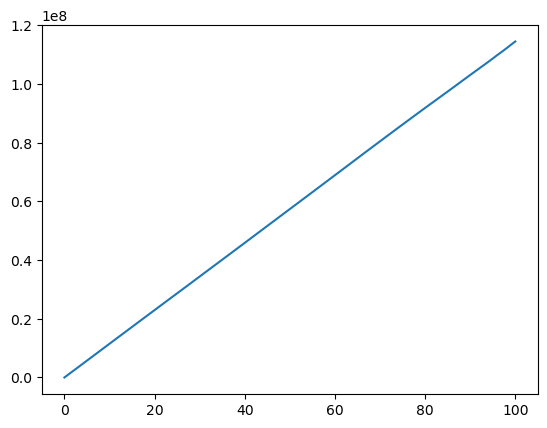

In [19]:
plt.plot(msd)


In [20]:
msd.shape

(101,)

In [21]:
time=np.array([i for i in range(0,101)])

In [22]:
time.shape

(101,)

In [23]:
#msd=6Dt,divided by particle numbers,timestep=10tau, and 6
print(f"Diffusion coefficient {np.polynomial.polynomial.polyfit(time,msd,deg=1)[1]/(6*20000*10)}")

Diffusion coefficient 0.9553697978735814


In [69]:
252351/(5000*6)



8.4117